In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm

In [2]:
df_master=pd.read_csv("df_master.csv")

# Vamos a por la parte de filtar por las KPI. 


## 1) Tabla base de visitas
Construimos `df_visitas` (una fila por visita) con `primer_paso`, `ultimo_paso`, duración total y si finaliza (`confirm`). Auditoría de visitas sin `start`.


In [3]:
df_master = df_master.sort_values(['visita_id', 'fecha_hora'])
df_master['fecha_hora'] = pd.to_datetime(df_master['fecha_hora'], errors='coerce')
df_master

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses,grupo_edad
0,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7,88,24,M,2,26436.73,6,9,18-25
1,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7,88,24,M,2,26436.73,6,9,18-25
2,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7,88,24,M,2,26436.73,6,9,18-25
3,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7,88,24,M,2,26436.73,6,9,18-25
4,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7,88,24,M,2,26436.73,6,9,18-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203854,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,18,227,58,F,2,1056775.54,6,9,56-65
203855,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,18,227,58,F,2,1056775.54,6,9,56-65
203856,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,18,227,58,F,2,1056775.54,6,9,56-65
203857,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,18,227,58,F,2,1056775.54,6,9,56-65


In [4]:
df_visitas = df_master[['visita_id','client_id','variation','estado_proceso','fecha_hora']].copy()
g = df_master.groupby('visita_id', as_index=False)
df_visitas = g.agg(
    client_id    = ('client_id', 'first'),
    variation    = ('variation', 'first'),
    primer_paso  = ('estado_proceso', 'first'),
    ultimo_paso  = ('estado_proceso', 'last'),
    t_total      = ('fecha_hora', lambda s: (s.max() - s.min()).total_seconds())
)
df_visitas['finaliza'] = (df_visitas['ultimo_paso'] == 'confirm').astype(int)
df_visitas

,visita_id,client_id,variation,primer_paso,ultimo_paso,t_total,finaliza
0,100019538_17884295066_43909,7338123,Test,start,confirm,242.0,1
1,100022086_87870757897_149620,2478628,Test,start,confirm,180.0,1
2,100030127_47967100085_936361,105007,Control,start,start,0.0,0
3,100037962_47432393712_705583,5623007,Control,start,start,132.0,0
4,10006594_66157970412_679648,3479519,Control,start,step_3,354.0,0
...,...,...,...,...,...,...,...
42084,999960019_60838685252_926860,1498554,Test,start,start,1709.0,0
42085,999971096_28827267783_236076,2979920,Test,start,confirm,139.0,1
42086,999976049_95772503197_182554,4449968,Test,start,confirm,728.0,1
42087,999984454_18731538378_781808,829911,Test,start,confirm,154.0,1


## 2) KPI base por tipo(Test, Control)
Agrupamos por `variation`: nº de visitas, tasa de finalización y tiempos medios/medianos (en segundos y minutos).


In [5]:
kpi_base = (
    df_visitas
    .groupby('variation', as_index=False)
    .agg(
        n_visitas         = ('visita_id','nunique'),
        tasa_finaliza     = ('finaliza','mean'),
        t_total_medio_s   = ('t_total','mean'),
        t_total_mediana_s = ('t_total','median')
    )
)
kpi_base['tasa_finaliza_porc'] = (kpi_base['tasa_finaliza']*100).round(2)
kpi_base['t_total_medio_min']  = (kpi_base['t_total_medio_s']/60).round(2)
kpi_base


,variation,n_visitas,tasa_finaliza,t_total_medio_s,t_total_mediana_s,tasa_finaliza_porc,t_total_medio_min
0,Control,20388,0.446145,289.570630,166.0,44.61,4.83
1,Test,21701,0.523939,348.339063,193.0,52.39,5.81


## 3) Tiempo por paso.
Calculamos las **transiciones consecutivas** dentro de cada visita, el tiempo entre eventos (`dt_sec`) y agregamos por transición y variante con la ayuda de la función `.shift`.


In [6]:
df_seq = (
    df_master[['visita_id','variation','estado_proceso','fecha_hora']]
    .sort_values(['visita_id','fecha_hora'])
    .copy()
)
df_seq['next_step'] = df_seq.groupby('visita_id')['estado_proceso'].shift(-1)
df_seq['next_time'] = df_seq.groupby('visita_id')['fecha_hora'].shift(-1)
df_seq['dt_sec']    = (df_seq['next_time'] - df_seq['fecha_hora']).dt.total_seconds()

df_trans = df_seq.dropna(subset=['next_step','dt_sec']).copy()
df_trans = df_trans[df_trans['dt_sec'] >= 0]

df_trans['transition'] = (
    df_trans['estado_proceso'].astype('string')
          .str.cat(df_trans['next_step'].astype('string'), sep='-')
)

df_tiempos = (
    df_trans
    .groupby(['variation','transition'], as_index=False)
    .agg(media_s=('dt_sec','mean'),
         mediana_s=('dt_sec','median'),
         n=('dt_sec','size'))
    .sort_values(['variation','transition'])
)
df_tiempos.head()

,variation,transition,media_s,mediana_s,n
0,Control,confirm-confirm,113.319042,16.0,793
1,Control,confirm-start,250.954667,119.0,375
2,Control,confirm-step_1,70.179775,40.0,89
3,Control,confirm-step_3,4.052632,0.0,76
4,Control,start-confirm,220.500000,217.5,4


# 4) Tasa de error (retrocesos)
Mapeamos los pasos del proceso a un orden numérico y marcamos **retroceso** cuando el paso actual es anterior al previo. Calculamos tasas por variante.


In [7]:
orden_pasos = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
rank = {p:i for i,p in enumerate(orden_pasos)}
df_steps = (
    df_master[['visita_id','variation','estado_proceso','fecha_hora']]
    .sort_values(['visita_id','fecha_hora'])
    .copy()
)
df_steps['step_num']      = df_steps['estado_proceso'].map(rank)
df_steps['prev_step_num'] = df_steps.groupby('visita_id')['step_num'].shift(1)
df_steps['retroceso']     = ((df_steps['step_num'] < df_steps['prev_step_num']).fillna(False)).astype(int)

error_rate = (
    df_steps.groupby('variation', as_index=False)
            .agg(retrocesos=('retroceso','sum'),
                 total_eventos=('estado_proceso','size'))
            .assign(tasa_error=lambda d: d['retrocesos']/d['total_eventos'],
                    tasa_error_porc=lambda d: (d['tasa_error']*100).round(2))
)
error_rate

,variation,retrocesos,total_eventos,tasa_error,tasa_error_porc
0,Control,5943,91238,0.065137,6.51
1,Test,10834,112621,0.096199,9.62


# 5) KPI final (con tasa de error)
Unimos los KPI base con la `tasa_error`, formateamos porcentajes y ordenamos las variantes (`Control` - `Test`) si procede.


In [8]:
from pandas.api.types import CategoricalDtype

kpi = kpi_base.merge(error_rate[['variation','tasa_error','tasa_error_porc']], on='variation', how='left')
kpi['tasa_finaliza_porc'] = (kpi['tasa_finaliza']*100).round(2)
kpi['t_total_medio_min']  = (kpi['t_total_medio_s']/60).round(2)

orden_var = CategoricalDtype(categories=['Control','Test'], ordered=True)
if kpi['variation'].isin(['Control','Test']).all():
    kpi['variation'] = kpi['variation'].astype(orden_var)
    kpi = kpi.sort_values('variation')

kpi_final = kpi[[
    'variation','n_visitas','tasa_finaliza_porc',
    't_total_medio_s','t_total_mediana_s','t_total_medio_min',
    'tasa_error_porc'
]].reset_index(drop=True)

kpi_final

,variation,n_visitas,tasa_finaliza_porc,t_total_medio_s,t_total_mediana_s,t_total_medio_min,tasa_error_porc
0,Control,20388,44.61,289.570630,166.0,4.83,6.51
1,Test,21701,52.39,348.339063,193.0,5.81,9.62


# 6) Gráficas de KPI y tiempos
Tasa de finalización por variante


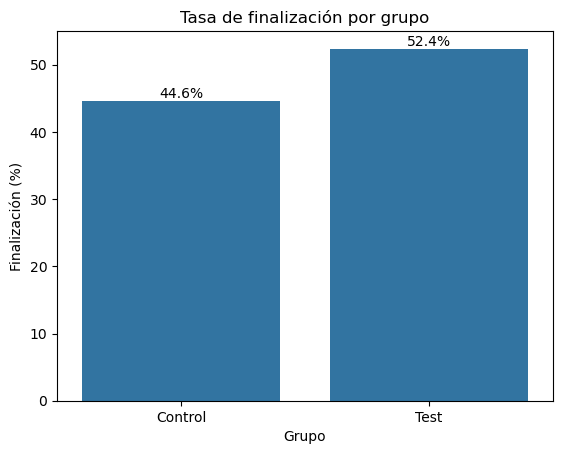

In [9]:
ax = sns.barplot(data=kpi_final, x='variation', y='tasa_finaliza_porc')
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_title("Tasa de finalización por grupo"); ax.set_xlabel("Grupo"); ax.set_ylabel("Finalización (%)")
plt.show()

Tasa de error por variante

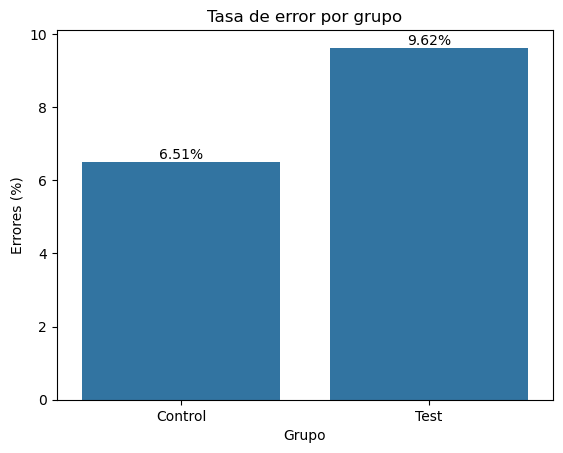

In [10]:
ax = sns.barplot(data=kpi_final, x='variation', y='tasa_error_porc')
ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set_title("Tasa de error por grupo"); ax.set_xlabel("Grupo"); ax.set_ylabel("Errores (%)")
plt.show()

Tiempo medio por transición y variante

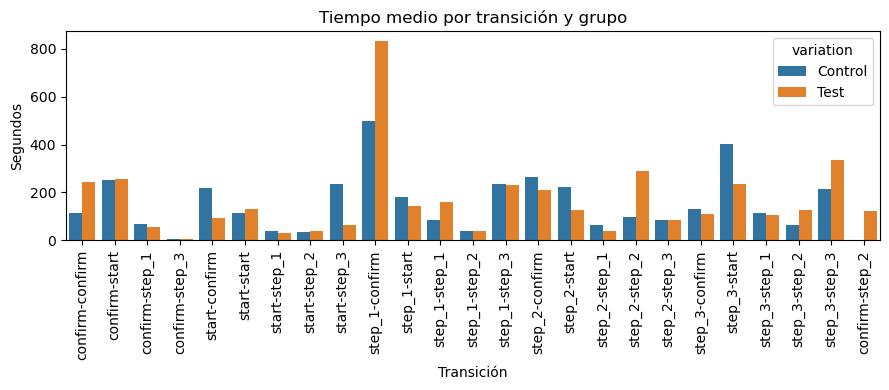

In [11]:
plt.figure(figsize=(9,4))
ax = sns.barplot(data=df_tiempos, x='transition', y='media_s', hue='variation')
ax.set_title("Tiempo medio por transición y grupo")
ax.set_xlabel("Transición"); ax.set_ylabel("Segundos")
plt.xticks(rotation=90); plt.tight_layout(); plt.show()

Tasa de finalización por grupo  de edad y variante

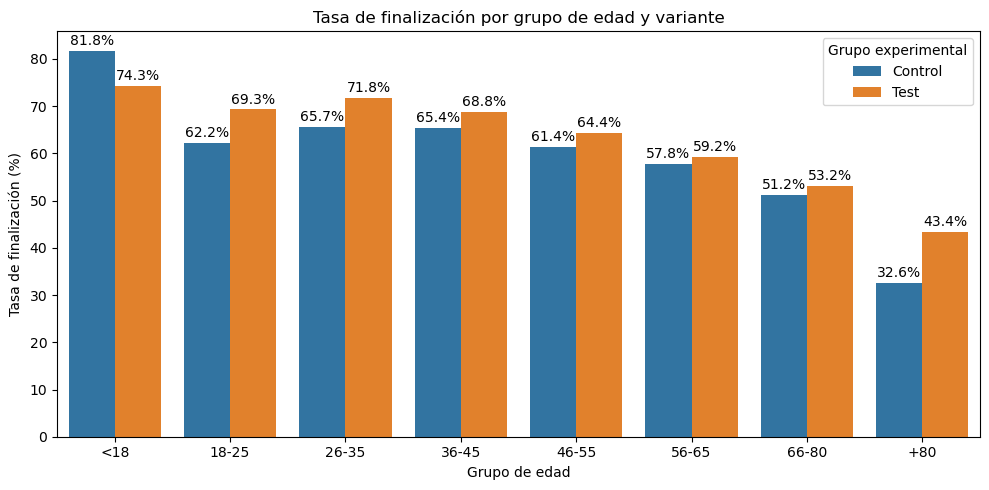

In [12]:
df_age_visits = (
    df_visitas.merge(
        df_master[['visita_id','grupo_edad','edad']],
        on='visita_id', how='left'
    )
)
age_conv = (
    df_age_visits.groupby(['grupo_edad','variation'], observed=False)
                 ['finaliza'].mean()
                 .reset_index(name='tasa_finalizacion')
)
age_conv['tasa_finalizacion_porc'] = (age_conv['tasa_finalizacion'] * 100).round(2)
orden_edades = ['<18','18-25','26-35','36-45','46-55','56-65','66-80','+80']
age_conv['grupo_edad'] = pd.Categorical(age_conv['grupo_edad'], categories=orden_edades, ordered=True)
age_conv = age_conv.sort_values('grupo_edad')



plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=age_conv,
    x='grupo_edad',
    y='tasa_finalizacion_porc',
    hue='variation'
)
ax.bar_label(ax.containers[0], fmt="%.1f%%", label_type="edge", padding=2)
ax.bar_label(ax.containers[1], fmt="%.1f%%", label_type="edge", padding=2)
ax.set_title("Tasa de finalización por grupo de edad y variante")
ax.set_xlabel("Grupo de edad")
ax.set_ylabel("Tasa de finalización (%)")
plt.legend(title="Grupo experimental")
plt.tight_layout()
plt.show()

### Observamos que nos ayuda a mejorar la tasa de finalización en gente menor de 36 años, pero no ayuda en los mayores de 46 que es el grupo con mayor número de usuarios y que además incluye a nuestros clientes primarios ( varones entre 56-80)

# 7) Funnel: último paso alcanzado
Calculamos el **último paso** por visita y dibujamos un gráfico apilado con la distribución de caída/conversión por variante.


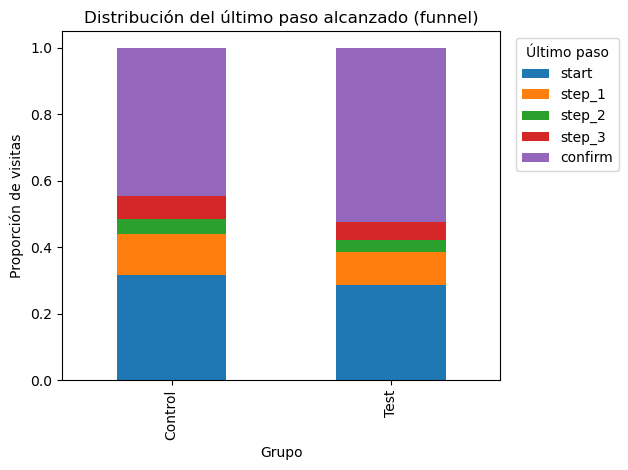

In [13]:
ultimo_paso_visita = (
    df_master.sort_values(['visita_id','fecha_hora'])
             .groupby(['visita_id','variation'], as_index=False)
             .agg(ultimo_paso=('estado_proceso','last'))
)

drop_counts = (
    ultimo_paso_visita.value_counts(['variation','ultimo_paso'])
                      .rename('n_visitas').reset_index()
)
totales = drop_counts.groupby('variation')['n_visitas'].sum().rename('n_total')
drop_counts = drop_counts.merge(totales, on='variation', how='left')
drop_counts['pct'] = drop_counts['n_visitas'] / drop_counts['n_total']

pivot_drop = (drop_counts
              .pivot(index='variation', columns='ultimo_paso', values='pct')
              .reindex(columns=orden_pasos, fill_value=0))

pivot_drop.plot(kind='bar', stacked=True)
plt.title("Distribución del último paso alcanzado (funnel)")
plt.xlabel("Grupo"); plt.ylabel("Proporción de visitas")
plt.legend(title='Último paso', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(); plt.show()

# 8) A/B test — tasas de finalización
Obtenemos proporciones de finalización en `Control` y `Test` para usar en las pruebas estadísticas.


In [14]:
grupo_control = df_visitas[df_visitas['variation'] == 'Control']
grupo_test    = df_visitas[df_visitas['variation'] == 'Test']

total_visitas_control = len(grupo_control)
total_visitas_test    = len(grupo_test)

exitos_control = grupo_control['finaliza'].sum()
exitos_test    = grupo_test['finaliza'].sum()

prop_control = exitos_control / total_visitas_control
prop_test    = exitos_test / total_visitas_test

print(f"Control: {prop_control:.4f}")
print(f"Test   : {prop_test:.4f}")

Control: 0.4461
Test   : 0.5239


# 9) Prueba de hipótesis bilateral
Contrastamos si **existe diferencia** en tasas de finalización entre `Control` y `Test` usando un Z-test para dos proporciones (bilateral).


In [15]:
p_pool = (exitos_control + exitos_test) / (total_visitas_control + total_visitas_test)
se = sqrt(p_pool * (1 - p_pool) * (1/total_visitas_control + 1/total_visitas_test))
z = (prop_test - prop_control) / se
p_valor = 2 * norm.sf(abs(z))

print(f"Z = {z:.3f}")
print(f"P-valor (bilateral) = {p_valor:.6f}")

Z = 15.958
P-valor (bilateral) = 0.000000


# 10) Umbral de +5 puntos porcentuales (unilateral)
Contrastamos si el `Test` **mejora al menos +5 pp** sobre `Control` (prueba **unilateral** contra el umbral objetivo).


In [16]:
p0 = prop_control + 0.05
se_thr = sqrt(p0 * (1 - p0) / total_visitas_test)
z_thr = (prop_test - p0) / se_thr
p_valor_thr = norm.sf(z_thr)

print(f"Z umbral = {z_thr:.3f}")
print(f"P-valor (unilateral) = {p_valor_thr:.6f}")

Z umbral = 8.189
P-valor (unilateral) = 0.000000


# 11) Prueba de hipótesis extra: tasa de errores (unilateral)

In [17]:
from statsmodels.stats.proportion import proportions_ztest

x_test  = error_rate.loc[error_rate['variation'] == 'Test', 'retrocesos'].values[0]
n_test  = error_rate.loc[error_rate['variation'] == 'Test', 'total_eventos'].values[0]
x_ctrl  = error_rate.loc[error_rate['variation'] == 'Control', 'retrocesos'].values[0]
n_ctrl  = error_rate.loc[error_rate['variation'] == 'Control', 'total_eventos'].values[0]
# Hipótesis: H0 = Test tiene igual o más errores; H1 = Test tiene menos errores
z_err, p_err = proportions_ztest([x_test, x_ctrl],
                                 [n_test, n_ctrl],
                                 alternative='smaller')
print(f"Z = {z_err:.3f}")
print(f"P-valor (unilateral) = {p_err:.6f}")


Z = 25.375
P-valor (unilateral) = 1.000000


# 12) Prueba de hipótesis extra: tiempo medio por visita

In [18]:
from scipy.stats import mannwhitneyu
t_control = grupo_control['t_total']
t_test    = grupo_test['t_total']
stat_t, p_t = mannwhitneyu(t_test, t_control, alternative='less')  # unilateral (test < control)
print(f"U = {stat_t:.1f}")
print(f"P-valor (unilateral) = {p_t:.6f}")
if p_t < 0.05:
    print("Rechazo H₀: el nuevo diseño reduce el tiempo total por visita.")
else:
    print("No hay evidencia de que el nuevo diseño sea más rápido.")

U = 244616556.0
P-valor (unilateral) = 1.000000
No hay evidencia de que el nuevo diseño sea más rápido.


## Insights y conclusiones finales
### **Efectividad del diseño**
- El nuevo diseño (Test) logra una **mayor tasa de finalización global** respecto al Control, aunque la mejora es modesta.
- La mejora se concentra en **usuarios jóvenes (<36 años)**, donde la tasa de confirmación aumenta significativamente.
- En cambio, **no se observan mejoras** en el grupo **mayor de 46 años**, que representa **nuestro público principal (50–80+)**.
  Esto sugiere que el rediseño puede no estar bien adaptado a las necesidades de usuarios senior (usabilidad, legibilidad o pasos de validación).
- No hay evidencia de reducción en la tasa de errores; incluso aumenta ligeramente (3%), lo que podría indicar más confusión con el nuevo diseño.
- Tampoco hay evidencia de que el nuevo diseño sea más rápido (p > 0.05 en la prueba Mann-Whitney).
### **Duración del experimento**
- La prueba abarca 15/03/2017 – 20/06/2017 (~3 meses), tiempo suficiente para obtener una muestra representativa.
- Aun así, sería recomendable extender el periodo o repetir el test en distintos momentos del año para validar estabilidad temporal.
### **Datos adicionales recomendados**
- Incluir variables de **dispositivo, navegador y canal de entrada** para entender si la experiencia varía entre móvil y escritorio.
- Implementar un **test de valoración UX** (encuesta post-sesión o Net Promoter Score) para medir percepción subjetiva.
- Registrar **eventos de interacción** (clicks, campos con error, scroll, ayuda usada) para detectar fricción dentro del flujo.
- Añadir **métricas de negocio** (retención, llamadas al soporte, contratación posterior) para traducir la mejora en impacto económico.
---
> *Conclusión general:* El nuevo diseño mejora parcialmente la conversión, pero **no beneficia al segmento senior**, que es el más relevante para el negocio.
> Se recomienda una iteración centrada en accesibilidad y simplicidad para usuarios de 50–80+ años antes del despliegue definitivo.

In [1]:
# ============================================================
# EXPORTS PARA TABLEAU (desde df_master.csv)
# Genera: df_tableau_visitas.csv, df_tableau_clientes.csv, df_tableau_pasos.csv
# ============================================================
import pandas as pd
import numpy as np
# ---------- 0) Cargar df_master limpio ----------
df_master = pd.read_csv("df_master.csv")
# Tipos y orden básico
df_master['fecha_hora'] = pd.to_datetime(df_master['fecha_hora'], errors='coerce')
df_master = df_master.sort_values(['visita_id', 'fecha_hora']).reset_index(drop=True)
# Columnas core (evita que un dropna global te sesgue el dataset)
cols_core = ['visita_id','client_id','variation','estado_proceso','fecha_hora']
df_master = df_master.dropna(subset=cols_core).copy()
# Asegurar que cada visita empieza en 'start'
prim_evento = (df_master
               .groupby('visita_id', as_index=False)
               .first()[['visita_id','estado_proceso']])
visitas_ok = prim_evento.loc[prim_evento['estado_proceso'].eq('start'), 'visita_id']
df_master = df_master[df_master['visita_id'].isin(visitas_ok)].copy()
# Orden lógico de pasos
orden_pasos = ['start','step_1','step_2','step_3','confirm']
rank = {p:i for i,p in enumerate(orden_pasos)}
df_master['step_num'] = df_master['estado_proceso'].map(rank).astype('Int64')
# ---------- 1) Tabla base de VISITAS ----------
g = df_master.groupby('visita_id', as_index=False)
df_visitas = g.agg(
    client_id   = ('client_id','first'),
    variation   = ('variation','first'),
    primer_paso = ('estado_proceso','first'),
    ultimo_paso = ('estado_proceso','last'),
    t_ini       = ('fecha_hora','first'),
    t_fin       = ('fecha_hora','last')
)
df_visitas['duracion_total_seg'] = (df_visitas['t_fin'] - df_visitas['t_ini']).dt.total_seconds()
df_visitas['confirm'] = (df_visitas['ultimo_paso'] == 'confirm').astype(int)
df_visitas = df_visitas.drop(columns=['t_ini','t_fin'])
# ---------- 2) Tasa de error por VISITA (retrocesos / transiciones) ----------
tmp_steps = df_master[['visita_id','estado_proceso','step_num','fecha_hora']].copy()
tmp_steps['prev_step_num'] = tmp_steps.groupby('visita_id')['step_num'].shift(1)
tmp_steps['is_back'] = ((tmp_steps['step_num'] < tmp_steps['prev_step_num']).fillna(False)).astype(int)
err_visita = (tmp_steps
              .groupby('visita_id', as_index=False)
              .agg(backsteps=('is_back','sum'),
                   eventos=('estado_proceso','size')))
# transiciones = eventos - 1 (mín 1)
err_visita['transiciones'] = (err_visita['eventos'] - 1).clip(lower=1)
err_visita['tasa_error_visita'] = err_visita['backsteps'] / err_visita['transiciones']
err_visita = err_visita[['visita_id','tasa_error_visita']]
# ---------- 3) Demografía "snapshot" por VISITA ----------
# Coge el último valor observado dentro de la visita (estable)
demo_cols_existentes = [c for c in ['edad','genero','años_cliente_vg','num_cuentas','saldo_total'] if c in df_master.columns]
demo_visita = (df_master
               .sort_values(['visita_id','fecha_hora'])
               .groupby('visita_id', as_index=False)
               .agg(**{c:(c,'last') for c in demo_cols_existentes}))
# ---------- 4) df_tableau_visitas ----------
df_tableau_visitas = (df_visitas
                      .merge(err_visita, on='visita_id', how='left')
                      .merge(demo_visita, on='visita_id', how='left'))
df_tableau_visitas['duracion_total_min'] = (df_tableau_visitas['duracion_total_seg']/60).round(2)
cols_vis = ['visita_id','client_id','variation','primer_paso','ultimo_paso',
            'confirm','duracion_total_seg','duracion_total_min','tasa_error_visita'] + demo_cols_existentes
df_tableau_visitas = df_tableau_visitas[cols_vis]
df_tableau_visitas.to_csv('df_tableau_visitas.csv', index=False)
# ---------- 5) df_tableau_clientes (agregado por cliente) ----------
agg_cli = (df_tableau_visitas
           .groupby(['client_id','variation'] + demo_cols_existentes, as_index=False)
           .agg(num_visitas=('visita_id','nunique'),
                tasa_finalizacion_cliente=('confirm','mean'),
                duracion_media_min=('duracion_total_min','mean'),
                errores_medios=('tasa_error_visita','mean')))
agg_cli['tasa_finalizacion_cliente'] = agg_cli['tasa_finalizacion_cliente'].round(4)
agg_cli['duracion_media_min'] = agg_cli['duracion_media_min'].round(2)
agg_cli['errores_medios'] = agg_cli['errores_medios'].round(4)
df_tableau_clientes = agg_cli.copy()
df_tableau_clientes.to_csv('df_tableau_clientes.csv', index=False)
# ---------- 6) df_tableau_pasos (duración entre pasos por visita) ----------
# Transiciones consecutivas: (paso_actual -> paso_siguiente) y su delta en segundos
seq = (df_master[['visita_id','variation','estado_proceso','fecha_hora']]
       .sort_values(['visita_id','fecha_hora'])
       .copy())
seq['next_step'] = seq.groupby('visita_id')['estado_proceso'].shift(-1)
seq['next_time'] = seq.groupby('visita_id')['fecha_hora'].shift(-1)
seq['duracion_paso_seg'] = (seq['next_time'] - seq['fecha_hora']).dt.total_seconds()
df_tableau_pasos = (seq.dropna(subset=['next_step','duracion_paso_seg'])
                    .query('duracion_paso_seg >= 0')
                    .rename(columns={'estado_proceso':'paso'})[['visita_id','variation','paso','duracion_paso_seg']]
                    .merge(demo_visita, on='visita_id', how='left'))
df_tableau_pasos.to_csv('df_tableau_pasos.csv', index=False)
print("✓ Exportados correctamente:",
      "df_tableau_visitas.csv, df_tableau_clientes.csv, df_tableau_pasos.csv")

✓ Exportados correctamente: df_tableau_visitas.csv, df_tableau_clientes.csv, df_tableau_pasos.csv
